In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [3]:
class GCN(nn.Module):
    def __init__(self,hid_dim,hid_dim1,hid_dim2):
        super(GCN,self).__init__()
        self.hid_dim=hid_dim
        self.hid_dim1=hid_dim1
        self.hid_dim2=hid_dim2
        A = [[1, 1, 0, 1, 1, 0, 0, 0, 0],
             [1, 1, 1, 1, 1, 1, 0, 0, 0],
             [0 ,1, 1, 0, 1, 1, 0, 0, 0],
             [1, 1, 0, 1, 1, 0, 1, 1, 0],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [0, 1, 1, 0, 1, 1, 0, 1, 1],
             [0, 0, 0, 1, 1, 0, 1, 1, 0],
             [0, 0, 0, 1, 1, 1, 1, 1, 1],
             [0, 0, 0, 0, 1, 1, 0, 1, 1]]
        adj=torch.FloatTensor(A)
        adj=adj.cuda()
        self.adj=adj
        self.W= nn.Parameter(torch.detach(torch.rand(5,self.hid_dim)).requires_grad_(True))
        self.W1= nn.Parameter(torch.detach(torch.rand(self.hid_dim,self.hid_dim1)).requires_grad_(True))#hid_dim이라 생각하면 편함
        self.W2= nn.Parameter(torch.detach(torch.rand(self.hid_dim1,self.hid_dim2)).requires_grad_(True))
        self.act = nn.Sigmoid()
        self.Linear=nn.Linear(self.hid_dim2,1)
        self.Linear1=nn.Linear(9,2)
        
    def forward(self,x):
        outs=[]
        out = torch.matmul(x,self.W)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W1)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W2)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        
        mic1,mic2,mic3,mic4,mic5,mic6,mic7,mic8,mic9=torch.chunk(out,9,-2)
        #print(mic1,mic1.shape)
        x1= self.Linear(mic1)
        x2= self.Linear(mic2)
        x3= self.Linear(mic3)
        x4= self.Linear(mic4)
        x5= self.Linear(mic5)
        x6= self.Linear(mic6)
        x7= self.Linear(mic7)
        x8= self.Linear(mic8)
        x9= self.Linear(mic9)
        out1=torch.cat([x1,x2,x3,x4,x5,x6,x7,x8,x9],1)
        out1=torch.squeeze(out1)
        out1=self.act(out1)
        out1 =self.Linear1(out1)
        return out1

In [4]:
def Visualize(x):
    model = torch.load('/home/lab/양창희/pytorch/pytorch_GCN/model/model_h_20h1_40.pt')
    model.cuda()
    model.eval()
    img=cv2.resize(x,(180,180), interpolation=cv2.INTER_CUBIC)
    ax1=plt.subplot(121)
    graph1=plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    test_result=[]
    for i in range(len(img)-3):
        for k in range(len(img[0])-3):
            make_data=img[i:i+3,k:k+3]
            test_result.append(make_data)
    test_result=np.array(test_result)
    AAA=Make_redemention(test_result)
    AAA=np.array(AAA,dtype=np.uint8)
    AAA1=reshape_demension(AAA)
    AAA1=np.array(AAA1)
    AAA1= (AAA1*(1/256)-0.5)/0.5
    test_input=torch.FloatTensor(AAA1)    
    test_input.shape
    result_data=[]
    for i in range(len(test_input)):
        in_test_result=test_input[i]
        in_test_result=in_test_result.cuda()
        out_test=model(in_test_result)
        #print(out_test)
        _, predicted = torch.max(out_test,-1)
        #print(predicted)
        result_data.append(predicted)        
    result_data=torch.tensor(result_data)
    result_data=np.array(result_data)
    result_data=result_data.tolist()    
    tototo=np.array(result_data)
    result_img=[]
    for i in range(len(img)-3):
        result_img1=[]
        for j in range(len(img[0])-3):
            if tototo[j+i*(len(img[0])-3)] ==0:
                result_img1.append([0,0,0])
            else:
                result_img1.append([255,255,255])
        result_img.append(result_img1)
        result_img1=[]
    result_img=np.array(result_img,dtype=np.uint8)
    for i in range(len(img)-3):
        for j in range(len(img[0])-3):
            if np.all(result_img[i][j]>=125) :
                img[i+1][j+1]=[0,0,0]
    ax2=plt.subplot(122)
    graph2=plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
def YCbCrTransform(x):
    #================= exponancial function ==================#
    exponancial=[[65.738, 129.057, 25.064],
                 [-37.945, -74.494, 112.439],
                 [112.439, -94.154, -18.285]]
    exponancial=np.matrix(exponancial)
    exponancial=(1/256)*exponancial
    
    A=[[16],[128],[128]]
    A=np.matrix(A)
    #=========================================================#
    x=np.matrix(x)
    x=np.transpose(x)
    Answer=A+exponancial*x
    Answer=np.array(Answer)
    Answer=Answer.tolist()
    Cb=Answer[1][0]
    Cr=Answer[2][0]
    
    return Cb,Cr
def Make_redemention(x):
    before_result=[]
    for i in range(x.shape[0]):    #x.shape[0]
        before_result1=[]
        for j in range(x.shape[1]):
            before_result2=[]
            for k in range(x.shape[2]):
                before_result3=[]
                before=x[i][j][k]
                Cb,Cr=YCbCrTransform(before)
                before_result3.append(before[0])
                before_result3.append(before[1])
                before_result3.append(before[2])
                before_result3.append(Cb)
                before_result3.append(Cr)
                before_result2.append(before_result3)
            before_result1.append(before_result2)
        before_result.append(before_result1)
    return before_result
def reshape_demension(x):
    make_result=[]
    for i in range(x.shape[0]):
        make_result1=[]
        for j in range(x.shape[1]):
            for k in range(x.shape[2]):
                make_result1.append(x[i][j][k])
        make_result.append(make_result1)
    return make_result

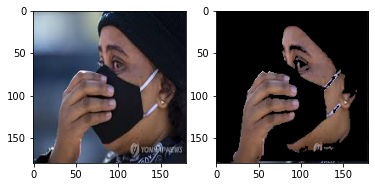

In [45]:
import cv2
img=cv2.imread('/home/lab/양창희/pytorch/pytorch_GCN/black1.jpg')
Visualize(img)

In [41]:
model2=GCN(6,6,6)

In [42]:
for name, param in model2.named_parameters():
    print(f'name:{name}')
    print(type(param))
    print(f'param.shape:{param.shape}')
    print(f'param.requries_grad:{param.requires_grad}')
    print('=====')

name:W
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([5, 6])
param.requries_grad:True
=====
name:W1
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([6, 6])
param.requries_grad:True
=====
name:W2
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([6, 6])
param.requries_grad:True
=====
name:Linear.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([1, 6])
param.requries_grad:True
=====
name:Linear.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([1])
param.requries_grad:True
=====
name:Linear1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([2, 9])
param.requries_grad:True
=====
name:Linear1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([2])
param.requries_grad:True
=====
